In [1]:
import sys
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path

input_size=40
train_size=128
validation_size=200
data_path='/run/media/klye/elements/kjetil/deleteme/kh_1.nc'

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.3,0.3]):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = 'rho'
    def area(self, I):
        
        return (I[0][1]-I[0][0])*(I[1][1]-I[1][0])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        return sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
    
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[0]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
    
    

In [3]:
def get_samples(data_path, functional):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
    
    print()
    return array(samples)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

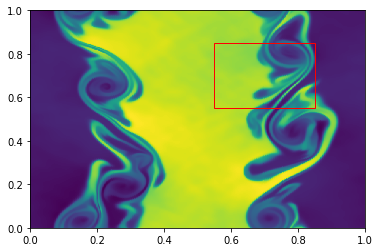

In [4]:
draw_functional(data_path, AreaFunctional())

In [5]:
def get_network_from_functional(data_path, functional, parameters):
    samples = get_samples(data_path, functional)
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size)
def get_network_from_functional_qmc(data_path, functional):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)
    print(parameters)
    print(parameters.shape)
    return get_network_from_functional(data_path, functional, parameters)
def get_network(parameters, data, *, train_size, validation_size, epochs=500000):
    input_size = parameters.shape[1]
    model = Sequential([
        Dense(20, input_shape=(input_size,)),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
  
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size]
   
    epochs_r=range(1, epochs)
   
    hist = model.fit(x_train, y_train,batch_size=train_size, epochs=epochs,shuffle=True,
          validation_data=(x_val, y_val),verbose=0)
    plt.loglog(hist.history['loss'])
    plt.show()
    plt.loglog(hist.history['loss'][4:])
    plt.show()
    plt.loglog(hist.history['loss'][400:])
    plt.show()
    plt.loglog(hist.history['val_loss'])
    plt.show()
    plt.loglog(hist.history['val_loss'][4:])
    plt.show()
    plt.loglog(hist.history['val_loss'][400:])
    plt.show()
    x_test = parameters
    y_test = data
    y_predict = model.predict(x_test)
    print(y_test.shape)
    print(y_predict.shape)
    plt.scatter(y_test, y_predict[:,0])
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    plt.show()
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data, parameters

In [6]:
def get_network_interpolate_qmc(data_path, functional):
    draw_functional(data_path, functional)
    network, data, parameters = get_network_from_functional_qmc(data_path, functional)
    
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    y_train = data[:train_size]
    coeffs = reg.fit(parameters[:train_size,:], y_train)

    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Least squares of degree 1')
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    plt.show()
    
    def myvar(x):
        mean = sum(x)/x.shape[0]
        var = sum((mean-x)**2)/x.shape[0]
        return var
    
    def mymean (x): 
        return sum(x)/x.shape[0]
    
    
   
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = network.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data- predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml/2.))
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = mymean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = mymean(network.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = mymean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    print("mean_lsq = %f" % mean(evaluated_lsq))
    
    
    
    
    predicted_all = network.predict(parameters)
    predicted_all = predicted_all.reshape(parameters.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = myvar(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = myvar(network.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = myvar(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    print("var_lsq = %f" % var(evaluated_lsq))
    
    return network, data, parameters

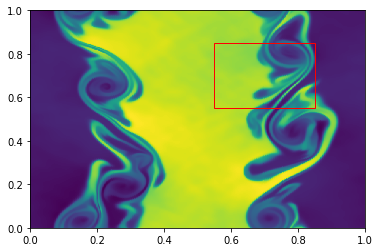

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.00000000e-01 5.00000000e-01 5.00000000e-01 ... 5.00000000e-01
  5.00000000e-01 5.00000000e-01]
 [7.50000000e-01 2.50000000e-01 7.50000000e-01 ... 7.50000000e-01
  7.50000000e-01 2.50000000e-01]
 ...
 [7.50122070e-01 7.83325195e-01 2.53540039e-01 ... 7.72583008e-01
  1.43920898e-01 4.57153320e-01]
 [5.00122070e-01 3.33251953e-02 3.54003906e-03 ... 5.22583008e-01
  3.93920898e-01 7.07153320e-01]
 [1.22070312e-04 5.33325195e-01 5.03540039e-01 ... 2.25830078e-02
  8.93920898e-01 2.07153320e-01]]
(8192, 40)
8191


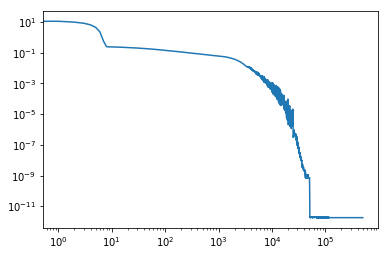

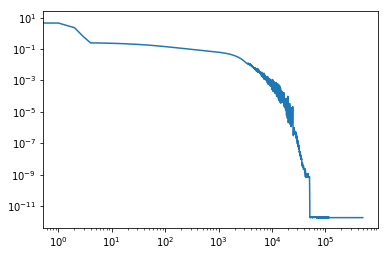

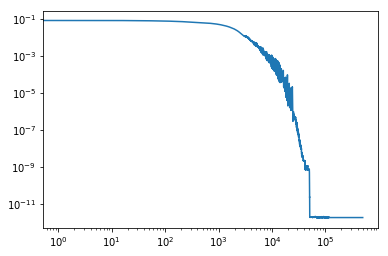

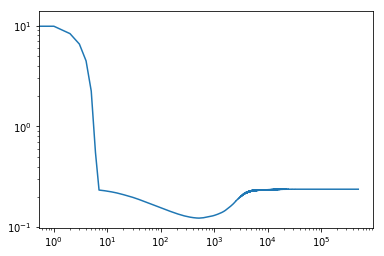

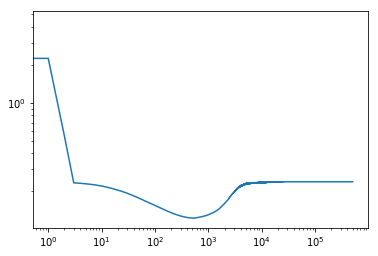

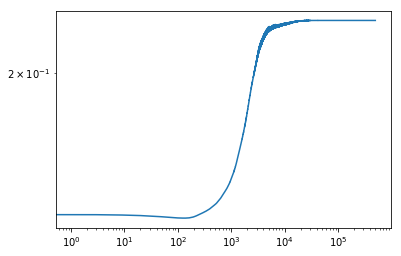

(8192,)
(8192, 1)


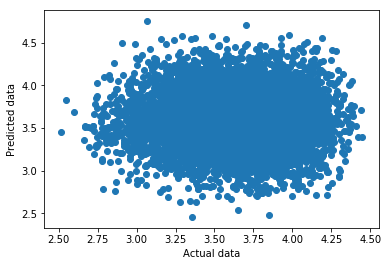

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                462       
_________________________________________________________________
activation_2 (Activation)    (None, 22)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                460       
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 22)                462       
__________

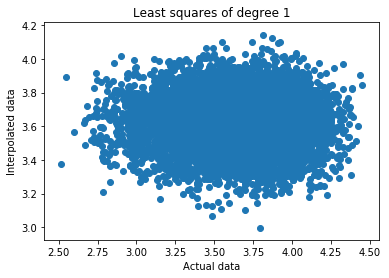

variance single level = 0.090638
variance diff ml = 0.181172 
speedup = 0.250142
(8192,)
variance_diff_interpolate = 0.114494
mean_qmc = 3.628535
mean_ml = 3.607787
mean_few_qmc = 19.843750
mean_lsq = 3.622045
(8192,)
mean_mlmlmc = 3.607787
var_qmc = 0.090638
var_ml = 0.091371
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.022158


In [7]:
network, data, parameters = get_network_interpolate_qmc(data_path, AreaFunctional())

In [8]:
samples = get_samples(data_path, AreaFunctional())

8191


[3.74071297 3.48632975 4.00207097 ... 3.41090474 4.03428021 3.60519378]


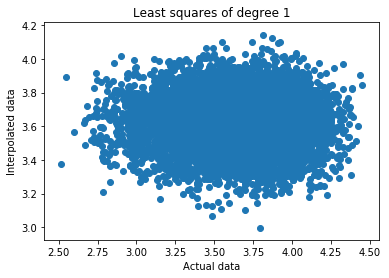

3.6220448008472492
3.62853547017509
0.09063758792479945
0.022157784228928404


In [9]:
parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
parameters = loadtxt(parameter_path)
from sklearn import linear_model
data = samples

print(data)
reg_size = 128
reg = linear_model.LinearRegression()
y_train = data[:reg_size]
coeffs = reg.fit(parameters[:reg_size,:], y_train)

evaluated_lsq = coeffs.predict(parameters)
plt.scatter(data, evaluated_lsq)
plt.title('Least squares of degree 1')
plt.xlabel("Actual data")
plt.ylabel("Interpolated data")
plt.show()
print(sum(evaluated_lsq)/len(evaluated_lsq))
print(sum(data)/len(data))
print(var(data))
print(var(evaluated_lsq))

In [10]:
func=AreaFunctional()
with netCDF4.Dataset(data_path) as f:
    d = f.variables['sample_10_rho'][:,:,0]
    r = func(d)
    print(r)

3.7121057428290936


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


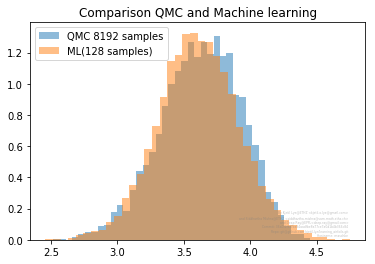

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


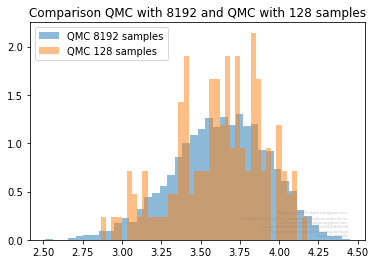

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


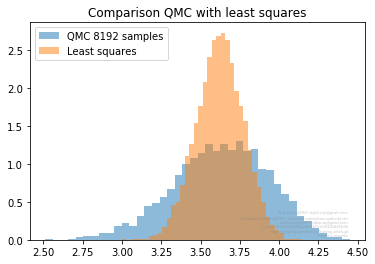

In [11]:
plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
plt.title("Comparison QMC and Machine learning")
plt.hist(network.predict(parameters),bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
plt.legend()
showAndSave('hist_qmc_ml')


plt.title("Comparison QMC with %d and QMC with %d samples" %(8192, train_size))
plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
plt.legend()
showAndSave('hist_qmc_qmc')

plt.title("Comparison QMC with least squares")
plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares')
plt.legend()
showAndSave('hist_qmc_lsq')
